In [ ]:
# %%

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV

import copy

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))

import importlib
import preprocessing.pipeline
importlib.reload(preprocessing.pipeline)
from preprocessing.pipeline import get_preprocessor

# === Additional imports for cross-validation ===
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

# XGBoost import
from xgboost import XGBRegressor

In [ ]:
# %%

# === Import data ===
train = pd.read_csv("../data/train.csv")
X_test = pd.read_csv("../data/test.csv")

X_train = train.drop("SalePrice", axis=1)
y_train = train["SalePrice"]

In [ ]:
# %%

# === Build preprocessing + modeling pipeline ===
model_pipeline = Pipeline([
  ("preprocessor", get_preprocessor()),
  ("model", TransformedTargetRegressor(
        regressor=XGBRegressor(
            n_estimators=100,
            random_state=42,
            verbosity=0,
            n_jobs=-1
        ),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

In [ ]:
# %%

# === Hyperparameter Tuning with GridSearchCV ===
param_grid = {
    "model__regressor__n_estimators": [200], # 50, 100
    "model__regressor__max_depth": [3], # 6, 10
    "model__regressor__learning_rate": [0.1], # 0.01, 0.05 
    "model__regressor__subsample": [0.8], # 0.6, 1.0
    "model__regressor__colsample_bytree": [0.8], # 0.6, 1.0
    "model__regressor__min_child_weight": [1], # 3, 5 
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=KFold(n_splits=10, shuffle=True, random_state=42),
                           scoring="neg_mean_squared_error",
                           n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

from sklearn.metrics import make_scorer

# Define log-transformed RMSE scorer
def root_mean_squared_error_log(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

rmse_scorer = make_scorer(root_mean_squared_error_log, greater_is_better=False)

# Cross-validated RMSE and R²
cv_rmse_scores = cross_val_score(model_pipeline, X_train, y_train, cv=KFold(n_splits=10, shuffle=True, random_state=42), scoring=rmse_scorer)
cv_r2_scores = cross_val_score(model_pipeline, X_train, y_train, cv=KFold(n_splits=10, shuffle=True, random_state=42), scoring="r2")

print(f"CV RMSE (log): {-np.mean(cv_rmse_scores):.2f}")
print(f"CV R² Score: {np.mean(cv_r2_scores):.4f}")

print(f"Best parameters: {grid_search.best_params_}")
# Convert best score to RMSE
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best CV RMSE: {best_rmse:.2f}")

# Use the best estimator from the search for further evaluation
model_pipeline = grid_search.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
CV RMSE (log): 0.14
CV R² Score: 0.8318
Best parameters: {'model__regressor__colsample_bytree': 0.8, 'model__regressor__learning_rate': 0.1, 'model__regressor__max_depth': 3, 'model__regressor__min_child_weight': 1, 'model__regressor__n_estimators': 200, 'model__regressor__subsample': 0.8}
Best CV RMSE: 26805.50


In [ ]:
# %%

# === Fit on full training data ===
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('drop_id',
                                                   ColumnDropper(columns_to_drop=['Id'])),
                                                  ('cat_na_fill',
                                                   CategoricalNaFiller(excluded_cols=['GarageYrBlt'])),
                                                  ('num_na_fill',
                                                   NumericalNaFiller(excluded_cols=['LotFrontage'])),
                                                  ('garage_bin',
                                                   GarageYrBltBinner()),
                                                  ('remove_outliers',
                                                   OutlierRemover()),
                                                  ('skewed_transf...
                                                                   feature_weights=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=3,
                                                                   max_leaves=None,
                                                                   min_child_weight=1,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=200,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None, ...)))])

In [ ]:
# %%

# === Evaluate on training data ===
y_train_pred = model_pipeline.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Train R² Score: {train_r2:.4f}")
train_rmse_log = np.sqrt(mean_squared_error(np.log1p(y_train), np.log1p(y_train_pred)))
print(f"Train RMSE (log): {train_rmse_log:.2f}")

Train RMSE: 12705.54
Train R² Score: 0.9744
Train RMSE (log): 0.07


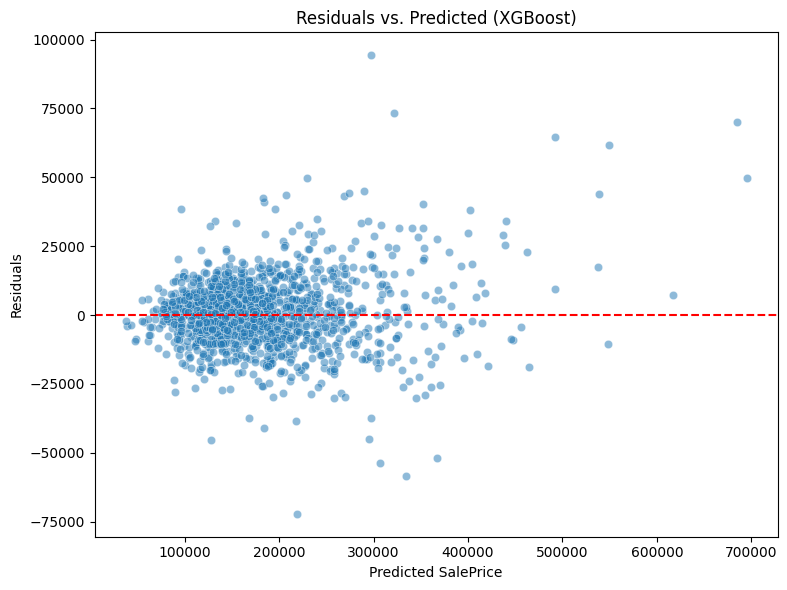

In [ ]:
# %%

# === Residual Plot ===
import seaborn as sns

residuals = y_train - y_train_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train_pred, y=residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted (XGBoost)")
plt.tight_layout()

residual_plot_dir = "../fig/xgb"
os.makedirs(residual_plot_dir, exist_ok=True)
plt.savefig(os.path.join(residual_plot_dir, "residuals_vs_predicted.png"))
plt.show()

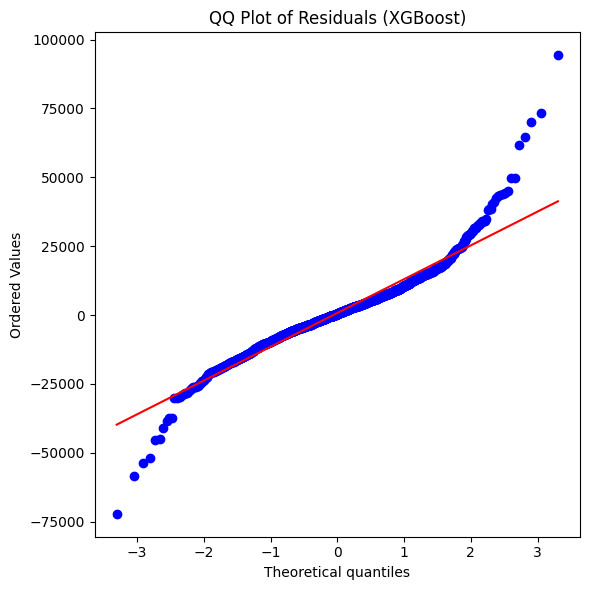

In [ ]:
# %%

# === QQ Plot ===
import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (XGBoost)")
plt.tight_layout()

qq_plot_path = os.path.join(residual_plot_dir, "qq_plot.png")
plt.savefig(qq_plot_path)
plt.show()


=== Feature Importances ===


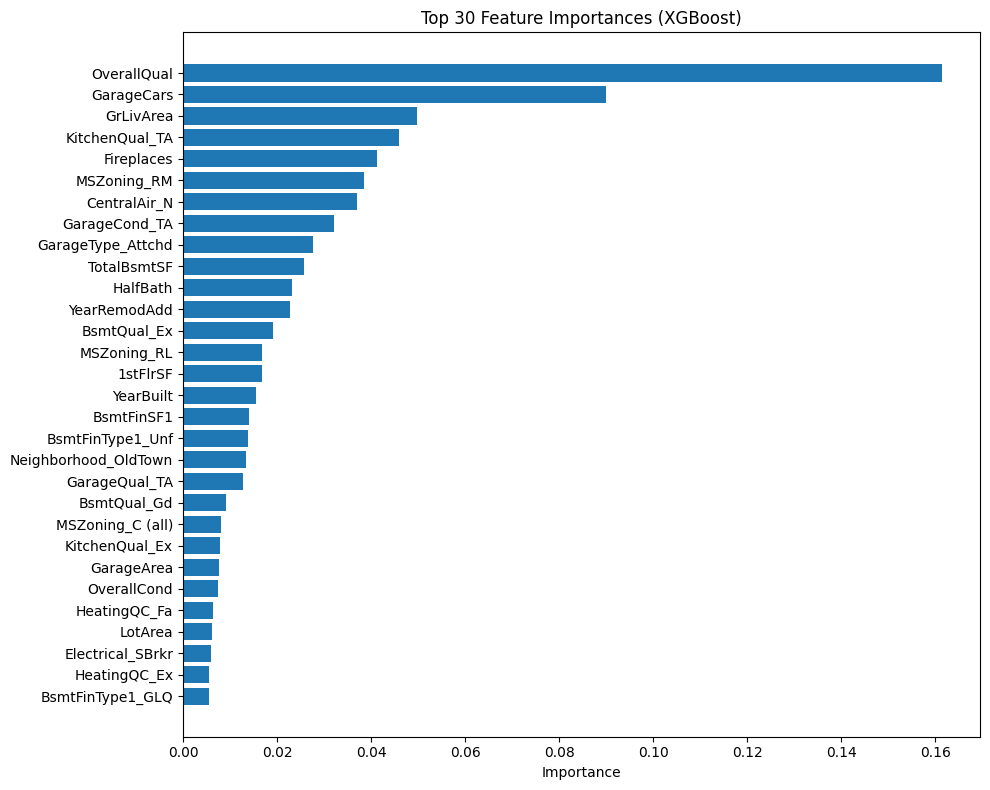

In [ ]:
# %%

# === Feature Importances ===
print("\n=== Feature Importances ===")
model = model_pipeline.named_steps["model"].regressor_
feature_names = model_pipeline.named_steps["preprocessor"].named_steps["transformer"].get_feature_names_out()
importances = model.feature_importances_

# Create a DataFrame for plotting
feat_imp_df = pd.DataFrame({
  "Feature": feature_names,
  "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df["Feature"][:30][::-1], feat_imp_df["Importance"][:30][::-1])
plt.xlabel("Importance")
plt.title("Top 30 Feature Importances (XGBoost)")
plt.tight_layout()

output_dir = "../fig/xgb"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "feature_importances.png"))

plt.show()

In [ ]:
# %%

# === Predict on test data ===
y_test_pred = model_pipeline.predict(X_test)

In [ ]:
# %%

# === Wrap in DataFrame ===
submission = pd.DataFrame({
  "Id": X_test["Id"],  # assuming 'Id' is in test data
  "SalePrice": y_test_pred
})

submission.head()

,Id,SalePrice
0,1461,127908.101562
1,1462,154378.375000
2,1463,180324.187500
3,1464,192856.218750
4,1465,185935.156250


In [ ]:
# %%

# === Save in submission file ===
submission.to_csv("../data/submission_xgb.csv", index=False)